In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
#import datetime
import matplotlib.dates as plt_d
from fuzzywuzzy import process, fuzz
import seaborn as sns
from dateutil.parser import parse
import difflib as diff

In [2]:
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

In [3]:
df_netflix = pd.read_csv('netflix_titles.csv')

In [4]:
display(df_netflix.head())
display(df_netflix.columns)
display(df_netflix.shape)
display(df_netflix.dtypes)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

(8807, 12)

show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object

# Question 1

### 1.1

In [5]:
display(df_netflix.describe(include=['O']))
display(df_netflix.groupby('type').describe(include=['O']))
display(df_netflix.describe())

,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,description
count,8807,8807,8807,6173,7982,7976,8797,8803,8804,8807,8807
unique,8807,2,8807,4528,7692,748,1767,17,220,514,8775
top,s1,Movie,Dick Johnson Is Dead,Rajiv Chilaka,David Attenborough,United States,"January 1, 2020",TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6131,1,19,19,2818,109,3207,1793,362,4


show_id                 title                                    \
          count unique top freq count unique                   top freq   
type                                                                      
Movie      6131   6131  s1    1  6131   6131  Dick Johnson Is Dead    1   
TV Show    2676   2676  s2    1  2676   2676         Blood & Water    1   

        director         ...  duration       listed_in         \
           count unique  ...       top  freq     count unique   
type                     ...                                    
Movie       5943   4354  ...    90 min   152      6131    278   
TV Show      230    222  ...  1 Season  1793      2676    236   

                                           description         \
                                  top freq       count unique   
type                                                            
Movie    Dramas, International Movies  362        6131   6105   
TV Show                      Kids' TV  220        2676   2672   

                                                                 
                                                       top freq  
type                                                             
Movie    Paranormal activity at a lush, abandoned prope...    4  
TV Show  This educational series for tiny tots features...    2  

[2 rows x 40 columns]

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


The dataset conssists of mostly string values, with only one numerical value - release_year. Therefore the dataset is described by included the 'O' parameter, for objects. Further it is thought it might be interesting to group by the types of entertainment provided, and then describe the dataset again.

### 1.2 

Here we check for blanks and duplicates. When considering duplicates we only look for the title, as many directors may be linked to different movies, duration times can be similar, the genre it is listed in is also non-unique.

In [6]:
display(df_netflix.isna().sum())

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [8]:
r1 = fuzz.ratio(df_netflix['title'].iloc[5318], df_netflix['title'].loc[5751])
print(df_netflix['title'].iloc[5318])
print(df_netflix['title'].loc[5751])
print(r1)

r2 = fuzz.ratio(df_netflix['title'].iloc[303], df_netflix['title'].loc[6705])
print(df_netflix['title'].iloc[303])
print(df_netflix['title'].loc[6705])
print(r2)

r3 = fuzz.ratio(df_netflix['title'].iloc[5033], df_netflix['title'].loc[5095])
print(df_netflix['title'].iloc[5033])
print(df_netflix['title'].loc[5096])
print(r3)

r4 = fuzz.ratio(df_netflix['title'].iloc[159], df_netflix['title'].loc[7345])
print(df_netflix['title'].iloc[159])
print(df_netflix['title'].loc[7345])
print(r4)

r5 = fuzz.ratio(df_netflix['title'].iloc[1270], df_netflix['title'].loc[8022])
print(df_netflix['title'].iloc[1270])
print(df_netflix['title'].loc[8022])
print(r5)

Death Note
DEATH NOTE
30
Esperando la carroza
Esperando La Carroza
90
FullMetal Alchemist
Fullmetal Alchemist: Brotherhood
95
Love in a Puff
Love In A Puff
86
Sin senos sí hay paraíso
Sin Senos sí Hay Paraíso
88


#### Blanks
It is found that directors have the most missing values with 2634, followed by country and cast with with 831 and 825 respectively. Maturity rating and duration also have a few missing values with 4 and 3 respectiviely. There are no other missing values

#### Duplicates
I tried finding duplicates using the fuzzy_merge method defined at the top, however as it is shown above this is no easy task due to the variations in ratio between duplicates which is further explained. Death Note and DEATH NOTE were thought to potentially be duplicates, however upon further investigation it was found that both a series and a movie exist, as it is represented in the dataset. Thus the all caps may have been represented this was so that it is not found to be a duplicate. A further issue for using the fuzzy_merge method is seen when analyzing Fullmetal Alchemist. In Anime, different season are considered seperate and often have different name as seen by Fullmetal Alchemist(Season 1) and Fullmetal Alchemist:Brotherhood(Season 2). These should be considered seperate shows as is done on Netflix, however the fuzzy_merge function would have found it to be a duplicate as the comaprison ratio is a high 95, higher than the other duplicates below it, which are actually duplicates. Love in a Puff and Sin senos sí hay paraíso are therefore the only 2 duplicates in the title column of the netflix dataset.

### 1.4

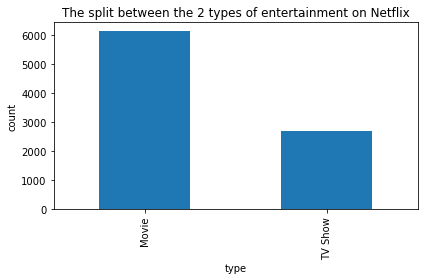

In [9]:
df_netflix.type.value_counts().plot.bar()
plt.xlabel('type')
plt.ylabel('count')
plt.title('The split between the 2 types of entertainment on Netflix')
plt.tight_layout()

This dataset contains 6131 movies and 2676 TV shows - there is more than double the amount of movies compared to TV shows.

### 1.5

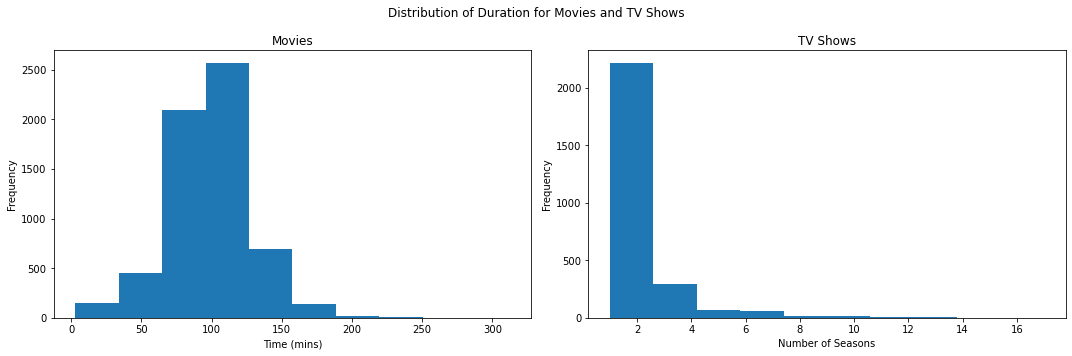

In [10]:
df_netflix['dur_min'] = df_netflix.duration.str.extract('(\d+)')
df_netflix.dur_min = pd.to_numeric(df_netflix.dur_min)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Distribution of Duration for Movies and TV Shows')
df_mov = df_netflix[df_netflix.type == 'Movie']
df_mov.dur_min.plot(kind='hist', ax=ax1, label='Histogram', xlabel='Time (min)')
#df_mov.dur_min.plot(kind='kde', ax=ax1, label='KDE', legend=True, xlabel='Time (min)')
ax1.set_xlabel('Time (mins)')
ax1.set_title('Movies')

df_tv = df_netflix[df_netflix.type == 'TV Show']
df_tv.dur_min.plot(kind='hist', ax=ax2, label='TV Show', xlabel='Number of Season')
ax2.set_xlabel('Number of Seasons')
ax2.set_title('TV Shows')
plt.tight_layout()

These are the distributions we expect to see. TV shows always produce a pilot season, and thereafter have the potential to get cancelled. There are very few TV shows that produce more than 7/8 seasons. People dont generally enjoy movies that are too long. It is common knowledge that most directors keep movies between 90 minutes, and maximally 180 minutes. However there are some outliers in which directors make movies longer than this. Short movies may be less than 60 minutes but are still considered movies.

### 1.6

Text(0.5, 1.0, 'The age of the content on Netflix')

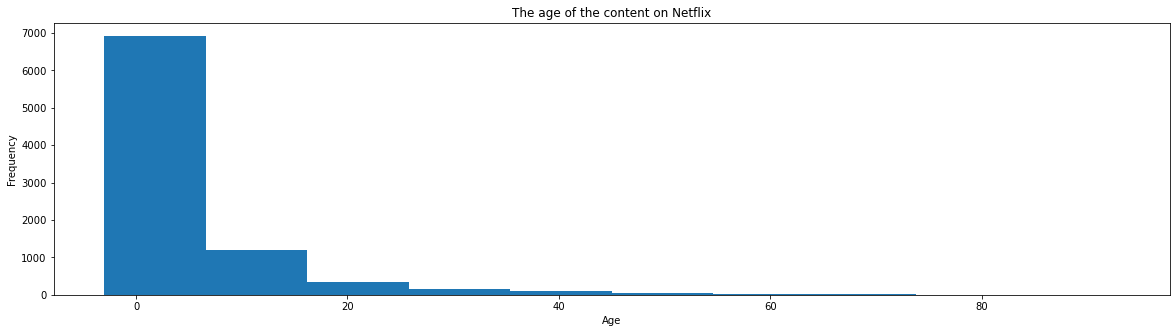

In [11]:
def format_date(el):
    return datetime.strptime(el, '%B %d, %Y').strftime('%Y')
date_added = df_netflix.date_added.str.strip()
date_added = pd.to_numeric(date_added.dropna().apply(format_date))
diff = date_added - df_netflix.release_year
df_netflix['difference'] = diff
diff.plot(kind='hist', figsize=(20, 5))
plt.xlabel('Age')
plt.title('The age of the content on Netflix')

The order to keep with the times, Netflix generally uploads current popular movies. They will add movies that are older than 20/30 years that are considered classics and are well known and popular.

Without IMDB data, it would be a difficult task to identify the content that Netflix produced. One could attempt to search for keywords such as "Netflix" in the description column, however this yields few results. If the data was more specific in terms of the full release date, as opposed to just the release year, one could looks for exact matches between te "date_added" and "release_date" columns. This is because Netflix Originals are generally uploaded to Netflix before or at the same time as dispersing it to other companies. Therefore, from the current data we are unable to locate a full list of content that Netflix itself produced.

### 1.7

<AxesSubplot:title={'center':'Age of Content distributed by Maturaty Rating'}, xlabel='rating,type', ylabel='Age'>

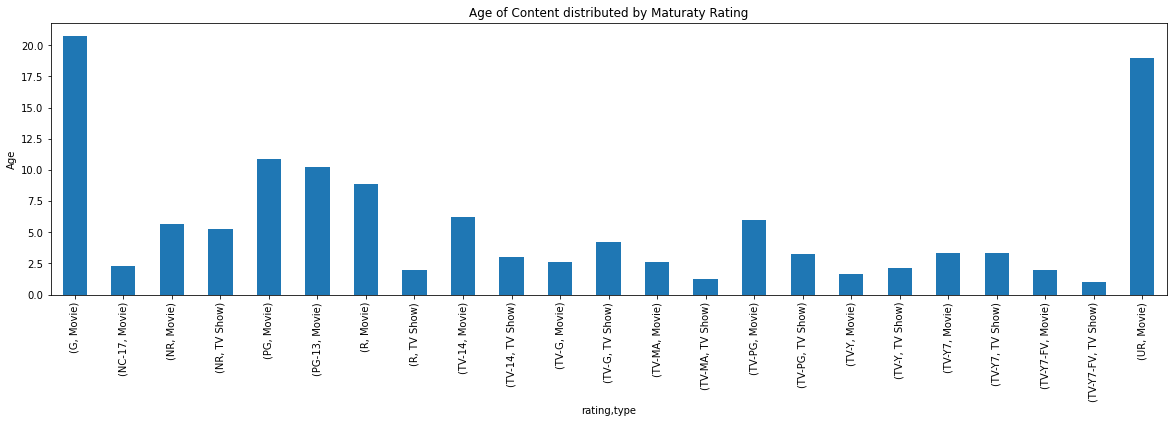

In [12]:
df_rating = df_netflix[df_netflix.rating != '66 min']
df_rating = df_rating[df_rating.rating != '74 min']
df_rating = df_rating[df_rating.rating != '84 min']

df_rating.groupby(['rating', 'type']).difference.mean().plot(kind='bar', figsize=(20, 5), title='Age of Content distributed by Maturaty Rating', ylabel='Age')

The maturaity rate contained some incorrect values, namely "66 min", "74 min", "84 min". These were removed as they are not maturaty ratings and are most likely due to human error when capturing the data. The agent of content distributed by maturaty rating was further split according to type, as this allows for a more in depth analysis for comparing the two types and are generally considered individually.

G movies have the highest mean age of content. This is expected as Netflix caters for a general audience, with movies taking up most of the dataset. R TV shows - not suitable for childern - have increasingly become more popular, namely shows such as Game of Thrones and The Witcher. With this recent increase in popularity, their mean age of content is among the lowest. A lot of the classics, such as Harry Potter and Twilight are considered PG and PG-13, and therefore also have quite a high mean age of content - as there are many classics.

### 1.8
Here, due to the vast nature of the different genres/categoris movies and tv shows fall into, I take only the first genre before the comma

514

36

<AxesSubplot:title={'center':'Age of Content distributed by Genre'}, xlabel='listed_in,type', ylabel='Age'>

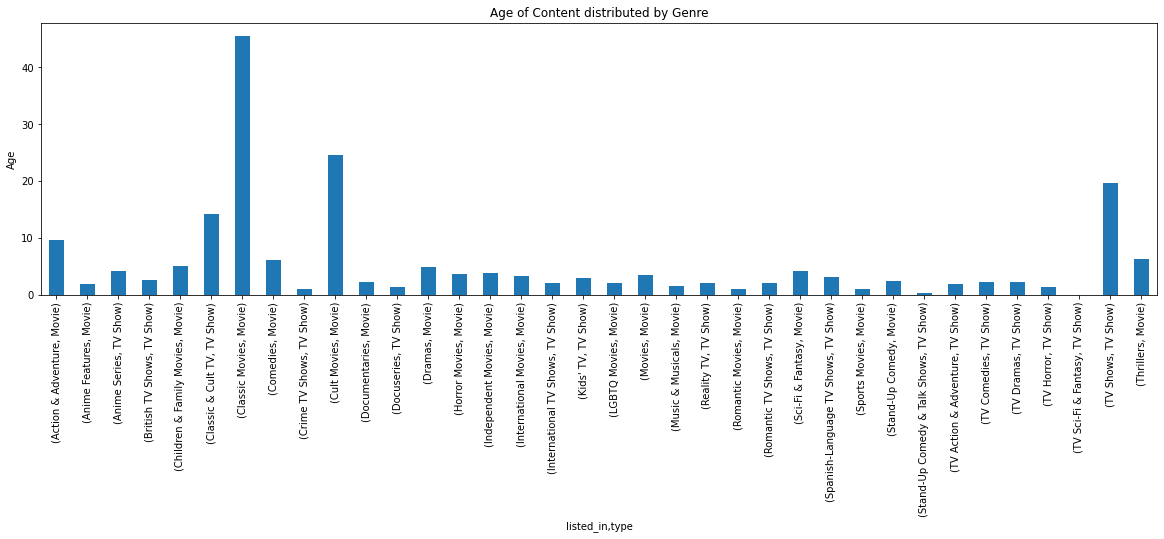

In [13]:
df_genre = df_netflix.copy()#.groupby('listed_in').difference.plot(kind='hist', legend=True)
display(df_genre.listed_in.nunique())
df_genre.listed_in = df_genre.listed_in.str.split(',', n=1).str.get(0)
display(df_genre.listed_in.nunique())

df_genre.groupby(['listed_in', 'type']).difference.mean().plot(kind='bar', figsize=(20, 5), ylabel='Age', title='Age of Content distributed by Genre')

Movies and TV shows may be categorized into a variety of genres. For this, the dataset includes a "listed_in" column to capture this. Using this however is not favourable, as ther are 514 unique representations of these categories. Therefore I took the first genre in the list and categorised the movie or TV show according to that, and reduced the unique entries to 36.

As expected, the "Classic Movies" genre has the highest mean age of content. This is because classics span the years of time, with some classic movies being produced prior to 1970. "Standup Comedy and Talk" is a more recent thing, growing in popularity due to comedians such as Trevor Noah. This therefore has the youngest mean age of content.

### 1.1.9

Text(0.5, 0, 'Amount')

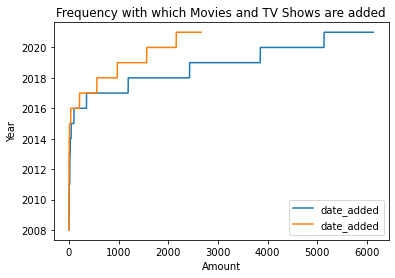

In [14]:
df_net_da = df_netflix.copy()
df_net_da['date_added'] = pd.to_datetime(df_netflix['date_added'].str.strip(), format='%B %d, %Y')
df_mov_da = df_net_da[df_net_da['type'] == 'Movie'].date_added.dt.year.sort_values(ascending=True).reset_index()
df_ser_da = df_net_da[df_net_da['type'] == 'TV Show'].date_added.dt.year.sort_values(ascending=True).reset_index()
df_mov_da = pd.DataFrame(df_mov_da, columns=['Idx', 'date_added'])
df_ser_da = pd.DataFrame(df_ser_da, columns=['Idx', 'date_added'])
df_mov_da = df_mov_da.drop('Idx', axis=1)
df_ser_da = df_ser_da.drop('Idx', axis=1)
ax = df_mov_da.plot(label='Movies', legend=True)
df_ser_da.plot(ax=ax)
plt.title("Frequency with which Movies and TV Shows are added")
plt.ylabel('Year')
plt.xlabel('Amount')
# df_mov_da.Idx = df_mov_da.index
# df_mov_da.Idx = df_mov_da.Idx.cumsum()
# df_ser_da.Idx = df_ser_da.index
# df_ser_da.Idx = df_ser_da.Idx.cumsum()
# ax = df_mov_da.plot(x='date_added', y='Idx', label='Movies')
# df_ser_da.plot(ax=ax,x='date_added', y='Idx', label='TV Shows')
# plt.title('The C')

This plot is a bit back to front, however when looking at the Years and the amounts that get added, we can deduce that Movies(blue) are added with more regularity to Netflix than TV Shows(orange). This is because they can be produced much faster, with past-time favourites regularly being added to cater to a wider audience.

### 1.1.10

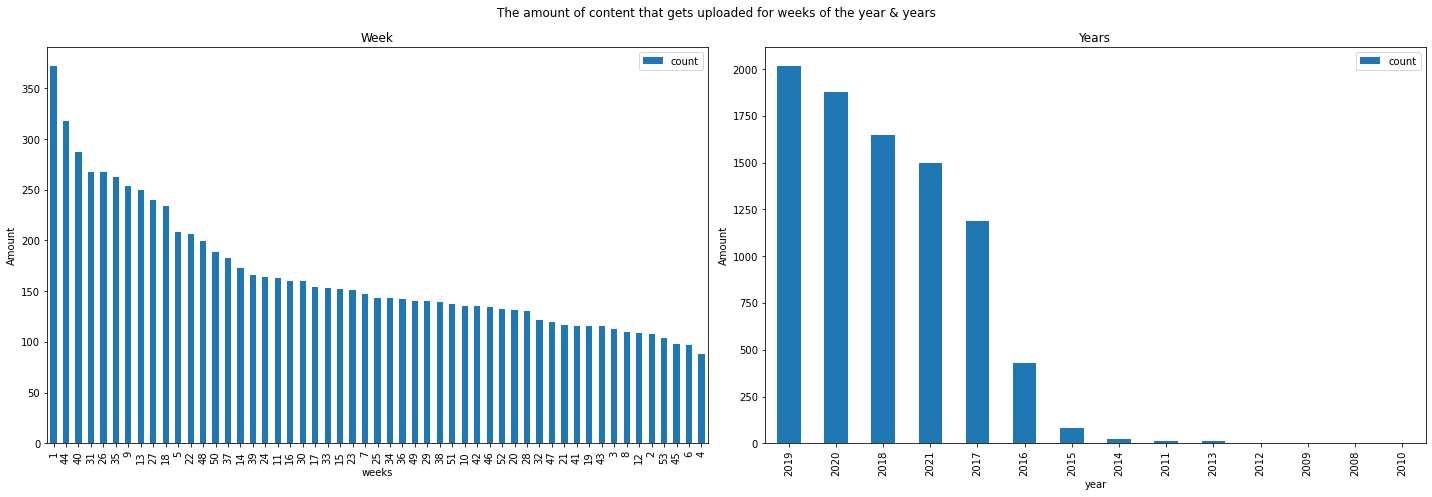

In [15]:
df_net_da_year = df_net_da.date_added.dt.year.astype('Int64').value_counts().sort_values(ascending=False)
df_net_da_week = df_net_da.date_added.dt.isocalendar().week.astype('Int64').value_counts().sort_values(ascending=False).T

df_net_da_year = pd.DataFrame([df_net_da_year.index, df_net_da_year]).T
df_net_da_year.columns = ['year','count']
df_net_da_week = pd.DataFrame([df_net_da_week.index, df_net_da_week]).T
df_net_da_week.columns = ['week', 'count']

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
fig.suptitle('The amount of content that gets uploaded for weeks of the year & years')
df_net_da_week.plot(kind='bar', x='week', y='count', ax=ax1)
ax1.set_title('Week')
ax1.set_xlabel('weeks')
ax1.set_ylabel('Amount')

df_net_da_year.plot(kind='bar', x='year', y='count', ax=ax2)
ax2.set_title('Years')
ax2.set_xlabel('year')
ax2.set_ylabel('Amount')
plt.tight_layout()

In terms of years, there is a definite trend with most uploads occuring after 2015 when Netflix gained a huge amount of popularity. 2019 beat 2020 as this is when covid started and production for movies to be released in 2020 we halted due to lockdowns.

In terms of weeks of the year, there is a trend of content being uploaded closer toward the end of the year, namely in October and November, just before christmas. The is also a large amount of content uploaded in January.

## 1.2

### 1.2.1

In [16]:
df_net_imdb = pd.read_csv('netflix_titles.csv')
df_net_imdb = df_net_imdb[df_net_imdb.type == 'Movie']

df_basics = pd.read_csv('title.basics_small.tsv.gz', delimiter='\t')
df_akas = pd.read_csv('title.akas_small.tsv.gz', delimiter='\t')
df_crew = pd.read_csv('title.crew_small.tsv.gz', delimiter='\t')
df_ep = pd.read_csv('title.episode_small.tsv.gz', delimiter='\t')
df_principals = pd.read_csv('title.principals_small.tsv.gz', delimiter='\t')
df_ratings = pd.read_csv('title.ratings_small.tsv.gz', delimiter='\t')
df_name = pd.read_csv('name.basics_small.tsv.gz', delimiter='\t')

In [17]:
df_net_imdb.shape

(6131, 12)

In [18]:
display(df_net_imdb.head())
display(df_net_imdb.shape)
display(df_net_imdb.columns)
display(df_basics.head())
display(df_basics.shape)
display(df_basics.columns)
display(df_ratings.head())
display(df_ratings.shape)
#display(df_crew.titleId.unique)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...


(6131, 12)

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt11394180,movie,Dick Johnson Is Dead,Dick Johnson Is Dead,0,2020,0,89,"Documentary,Drama"
1,tt5973706,movie,The Wake of Dick Johnson,The Wake of Dick Johnson,0,2016,0,74,Drama
2,tt3172066,tvEpisode,Jack Johnson,Jack Johnson,0,2013,0,22,"Comedy,News,Talk-Show"
3,tt0065906,movie,Jack Johnson,Jack Johnson,0,1970,0,90,"Documentary,Sport"
4,tt13604988,tvSeries,Johnson,Johnson,0,2021,0,30,"Comedy,Drama"


(138070, 9)

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')

,tconst,averageRating,numVotes
0,tt0000004,6.0,153
1,tt0000020,5.0,319
2,tt0000023,5.7,1293
3,tt0000031,5.5,936
4,tt0000051,3.8,32


(114155, 3)

In [19]:
df_basics = df_basics.drop_duplicates(subset='tconst', keep='first')
df_ratings = df_ratings.drop_duplicates(subset='tconst', keep='first')
display(df_basics.shape)
display(df_ratings.shape)

(114155, 9)

(114155, 3)

In [20]:
df_comb = pd.merge(df_basics, df_ratings, left_on = 'tconst', right_on = 'tconst', how='left')
df_comb = df_comb.drop_duplicates(subset='primaryTitle', keep='first')
display(df_comb.shape)
df_comb.head()

(93438, 11)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt11394180,movie,Dick Johnson Is Dead,Dick Johnson Is Dead,0,2020,0,89,"Documentary,Drama",7.4,5870
1,tt5973706,movie,The Wake of Dick Johnson,The Wake of Dick Johnson,0,2016,0,74,Drama,8.5,7
2,tt3172066,tvEpisode,Jack Johnson,Jack Johnson,0,2013,0,22,"Comedy,News,Talk-Show",8.2,13
4,tt13604988,tvSeries,Johnson,Johnson,0,2021,0,30,"Comedy,Drama",4.6,116
5,tt4831846,tvEpisode,Johnson & Johnson,Johnson & Johnson,0,2016,0,21,Comedy,7.1,203


In [21]:
df_net_imdb = pd.merge(df_net_imdb, df_comb, left_on = 'title', right_on = 'primaryTitle', how='left')

In [22]:
display(df_comb.shape)
display(df_net_imdb.shape)
display(df_net_imdb.head())
df_net_imdb.averageRating

(93438, 11)

(6131, 23)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,...,movie,Dick Johnson Is Dead,Dick Johnson Is Dead,0.0,2020.0,0.0,89.0,"Documentary,Drama",7.4,5870.0
1,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,...,movie,My Little Pony: A New Generation,My Little Pony: A New Generation,0.0,2021.0,0.0,90.0,"Adventure,Animation,Comedy",6.9,2702.0
2,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,...,movie,Sankofa,Sankofa,0.0,1993.0,0.0,125.0,Drama,7.0,617.0
3,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,...,movie,The Starling,The Starling,0.0,2021.0,0.0,102.0,"Comedy,Drama",6.3,9145.0
4,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,...,movie,Je Suis Karl,Je Suis Karl,0.0,2021.0,0.0,126.0,"Drama,Romance,Thriller",5.4,613.0


0       7.4
1       6.9
2       7.0
3       6.3
4       5.4
       ... 
6126    8.1
6127    7.7
6128    5.9
6129    6.8
6130    8.0
Name: averageRating, Length: 6131, dtype: float64

In [23]:
display(df_net_imdb[['title', 'averageRating']].head(20))
display(df_net_imdb[['title', 'averageRating']].isna().sum())
display(df_net_imdb[df_net_imdb['averageRating'] >= 10])

,title,averageRating
0,Dick Johnson Is Dead,7.4
1,My Little Pony: A New Generation,6.9
2,Sankofa,7.0
3,The Starling,6.3
4,Je Suis Karl,5.4
5,Confessions of an Invisible Girl,5.2
6,Europe's Most Dangerous Man: Otto Skorzeny in ...,NaN
7,Intrusion,8.4
8,Avvai Shanmughi,NaN
9,Go! Go! Cory Carson: Chrissy Takes the Wheel,5.8


title               0
averageRating    1185
dtype: int64

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
2656,s4192,Movie,Pari,Syed Atif Ali,"Junaid Akhtar, Azekah Daniel, Khushi Maheen, S...",Pakistan,"January 15, 2019",2018,TV-14,116 min,...,short,Pari,Pari,0.0,2012.0,0.0,21.0,"Comedy,Short",10.0,6.0


The ratings make sense and are all between the values of 0 and 10. However due to this naive implementation, it can still be seen that there are 1185 ratings that have not been linked to movies and are empty. There are just too many movies to find the rating of each movie individually. One movie has a rating of 10, which isnt expected since we are looking at average ratings, however only 6 votes were cast.

### 1.2.2

In [24]:
missing_r = df_net_imdb.index[df_net_imdb['averageRating'].isna()].to_list()
df_missing_r = df_net_imdb.loc[missing_r]
df_missing_r = df_missing_r.iloc[:, :12]
display(df_missing_r.head())
print('There are {} average ratings missing for movies currently'.format(df_missing_r.shape[0]))

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
6,s17,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",NaN,NaN,"September 22, 2021",2020,TV-MA,67 min,"Documentaries, International Movies",Declassified documents reveal the post-WWII li...
8,s23,Movie,Avvai Shanmughi,K.S. Ravikumar,"Kamal Hassan, Meena, Gemini Ganesan, Heera Raj...",NaN,"September 21, 2021",1996,TV-PG,161 min,"Comedies, International Movies",Newly divorced and denied visitation rights wi...
11,s27,Movie,Minsara Kanavu,Rajiv Menon,"Arvind Swamy, Kajol, Prabhu Deva, Nassar, S.P....",NaN,"September 21, 2021",1997,TV-PG,147 min,"Comedies, International Movies, Music & Musicals",A tangled love triangle ensues when a man fall...
21,s44,Movie,Jaws 3,Joe Alves,"Dennis Quaid, Bess Armstrong, Simon MacCorkind...",United States,"September 16, 2021",1983,PG,98 min,"Action & Adventure, Horror Movies, Thrillers",After the staff of a marine theme park try to ...
28,s54,Movie,InuYasha the Movie 4: Fire on the Mystic Island,Toshiya Shinohara,"Kappei Yamaguchi, Satsuki Yukino, Koji Tsujita...",Japan,"September 15, 2021",2004,TV-PG,88 min,"Action & Adventure, Anime Features, Internatio...","Ai, a young half-demon who has escaped from Ho..."


There are 1185 average ratings missing for movies currently


In [25]:
df_c = pd.merge(df_basics, df_ratings, left_on = 'tconst', right_on = 'tconst', how='left')
df_c = df_c.drop_duplicates(subset='primaryTitle', keep='first')
display(df_c.shape)
df_c.head()

(93438, 11)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt11394180,movie,Dick Johnson Is Dead,Dick Johnson Is Dead,0,2020,0,89,"Documentary,Drama",7.4,5870
1,tt5973706,movie,The Wake of Dick Johnson,The Wake of Dick Johnson,0,2016,0,74,Drama,8.5,7
2,tt3172066,tvEpisode,Jack Johnson,Jack Johnson,0,2013,0,22,"Comedy,News,Talk-Show",8.2,13
4,tt13604988,tvSeries,Johnson,Johnson,0,2021,0,30,"Comedy,Drama",4.6,116
5,tt4831846,tvEpisode,Johnson & Johnson,Johnson & Johnson,0,2016,0,21,Comedy,7.1,203


In [26]:
new_df = fuzzy_merge(df_missing_r, df_c, 'title', 'primaryTitle', threshold=95)

In [30]:
df_new_1 = pd.merge(new_df, df_c, left_on='matches', right_on='primaryTitle', how='left')

In [31]:
new_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,matches
6,s17,Movie,Europe's Most Dangerous Man: Otto Skorzeny in ...,"Pedro de Echave García, Pablo Azorín Williams",NaN,NaN,"September 22, 2021",2020,TV-MA,67 min,"Documentaries, International Movies",Declassified documents reveal the post-WWII li...,
8,s23,Movie,Avvai Shanmughi,K.S. Ravikumar,"Kamal Hassan, Meena, Gemini Ganesan, Heera Raj...",NaN,"September 21, 2021",1996,TV-PG,161 min,"Comedies, International Movies",Newly divorced and denied visitation rights wi...,Avvai Shanmugi
11,s27,Movie,Minsara Kanavu,Rajiv Menon,"Arvind Swamy, Kajol, Prabhu Deva, Nassar, S.P....",NaN,"September 21, 2021",1997,TV-PG,147 min,"Comedies, International Movies, Music & Musicals",A tangled love triangle ensues when a man fall...,Minsaara Kanavu
21,s44,Movie,Jaws 3,Joe Alves,"Dennis Quaid, Bess Armstrong, Simon MacCorkind...",United States,"September 16, 2021",1983,PG,98 min,"Action & Adventure, Horror Movies, Thrillers",After the staff of a marine theme park try to ...,Jaws 3-D
28,s54,Movie,InuYasha the Movie 4: Fire on the Mystic Island,Toshiya Shinohara,"Kappei Yamaguchi, Satsuki Yukino, Koji Tsujita...",Japan,"September 15, 2021",2004,TV-PG,88 min,"Action & Adventure, Anime Features, Internatio...","Ai, a young half-demon who has escaped from Ho...",Inuyasha the Movie 4: Fire on the Mystic Island
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,s8779,Movie,Yes or No 2,Saratswadee Wongsomphet,"Supanart Jittaleela, Sushar Manaying, Nisa Boo...",Thailand,"November 8, 2018",2012,TV-PG,112 min,"International Movies, LGBTQ Movies, Romantic M...","No longer university girls, Kim and Pie face n...","Yes or No, Yes or No 2.5"
6112,s8782,Movie,Yo-Kai Watch: The Movie,Mark Risley,"Johnny Yong Bosch, Joey D'Auria, Alicyn Packar...","Japan, United States","December 1, 2016",2016,TV-Y7,96 min,"Anime Features, Children & Family Movies",Nate's special Yo-Kai Watch is missing. He tra...,"Movie: The Movie, Yo-kai Watch the Movie 6"
6114,s8785,Movie,Yoko and His Friends,NaN,"Eileen Stevens, Alyson Leigh Rosenfeld, Sarah ...","Russia, Spain","June 23, 2018",2015,TV-Y,78 min,Children & Family Movies,"Vik meets new friends in a new city, where the...",Yoko & his friends
6116,s8788,Movie,You Can’t Fight Christmas,Kenny Young,"Brely Evans, Andra Fuller, Persia White, Porsc...",United States,"December 19, 2017",2017,TV-PG,85 min,"Comedies, Romantic Movies",After stepping in to revitalize his family's h...,You Can't Fight Christmas


In [32]:
new_df.matches = new_df.matches.str.split(',', n=1).str.get(0)

In [38]:
print('There are now, after cleaning, only {} average ratings missing for movies from the earlier 1185'.format(df_new_1.averageRating.isna().sum()))

There are now, after cleaning, only 655 average ratings missing for movies from the earlier 1185


Using the FuzzyWuzzy package and a threshold of 95 as the minimum ratio that allows 'title' and 'primaryTitle' to be considered a match, the number of missing average ratings has been successfully decreased from 1185 to 655. These matches are what we are looking for and can be viewed in the 'matches' column above. If there was more than one match found with a ratio greater than 95, the first was chosen, as they are ordered in highest to lowest ratio above the threshold. The results, as before, still make sense and are between 0 and 10, however this should allow now for a more accurate representation of Netflix's contents average rating, due to the decrease in missing values. 

### 1.2.3

Text(0.5, 1.0, 'Boxplot for Average Ratings of Movies on Netflix')

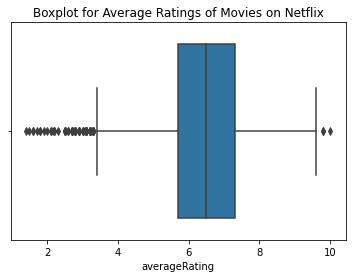

In [41]:
idx = df_new_1.index[df_new_1.matches.notna()].to_list()
df_idx = df_new_1.loc[idx]

df_new_2 = df_net_imdb.copy()
df_new_2['new'] = df_idx.matches

ax=sns.boxplot(x=df_new_2['averageRating'])
ax.set_title('Boxplot for Average Ratings of Movies on Netflix')

Netflix has a decent quality of movie content. It is above average with the mean sitting at ~6.5. Its 25th percentile sits at ~5.75 and the 75th percentile at ~7.5. The minimum is at ~3.5 showing that they do have content that is far below average, with the maximum at ~9.8. There are a few outliers as can be seen.

### 1.2.4

In [25]:
df_rel = df_net_imdb[['title', 'duration', 'genres', 'director', 'cast', 'averageRating']].copy()
df_rel.genres = df_rel.genres.str.split(',', n=1).str.get(0)
df_rel['duration'] = df_rel.duration.str.extract('(\d+)')
df_rel['duration'] = pd.to_numeric(df_rel['duration'])
display(df_rel.head())
display(df_rel.dtypes)

,title,duration,genres,director,cast,averageRating
0,Dick Johnson Is Dead,90.0,Documentary,Kirsten Johnson,NaN,7.4
1,My Little Pony: A New Generation,91.0,Adventure,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",6.9
2,Sankofa,125.0,Drama,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...",7.0
3,The Starling,104.0,Comedy,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",6.3
4,Je Suis Karl,127.0,Drama,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...",5.4


title             object
duration         float64
genres            object
director          object
cast              object
averageRating    float64
dtype: object

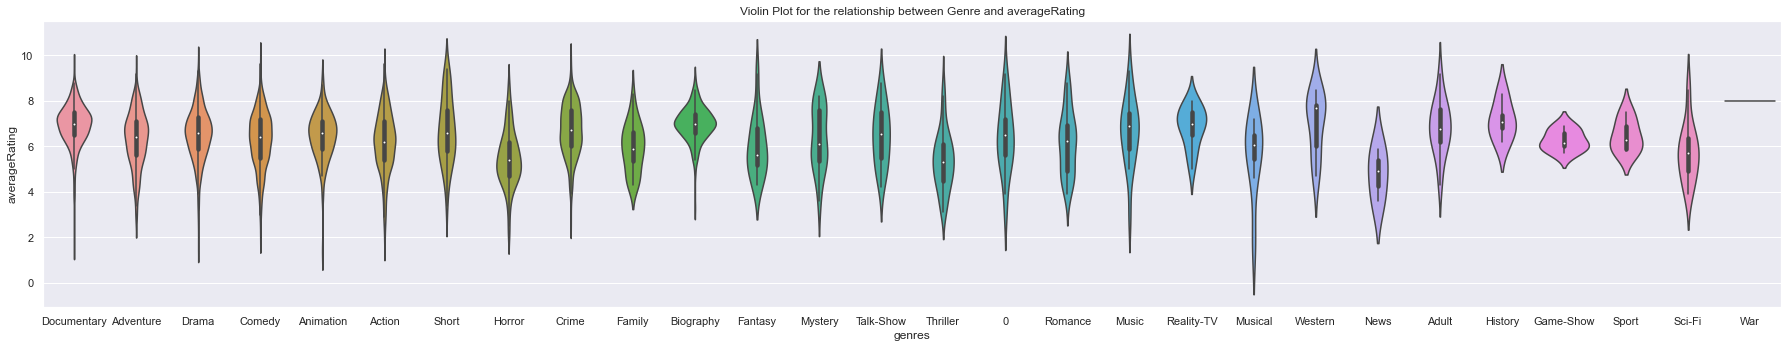

In [27]:
ax=sns.set(rc = {'figure.figsize':(25,5)})
ax=sns.violinplot(x = "genres", y="averageRating", data=df_rel, fit_reg = False, scatter_kws={"alpha": 0.2})
ax.set_title('Violin Plot for the relationship between Genre and averageRating')
plt.tight_layout()

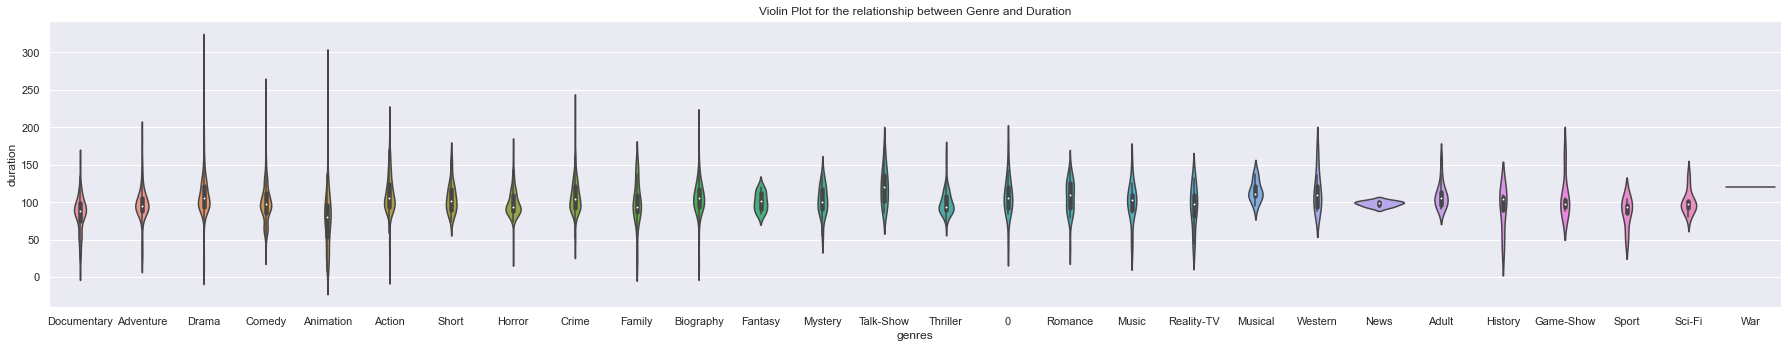

In [29]:
ax = sns.set(rc = {'figure.figsize':(25,5)})
ax = sns.violinplot(x = "genres", y="duration", data=df_rel, fit_reg = False, scatter_kws={"alpha": 0.2})
ax.set_title('Violin Plot for the relationship between Genre and Duration')
plt.tight_layout()

Animation appears to have the highest variance in terms of duration, with the News being among the most consistent - which makes sense. Western and Adult appear to have the highest ratings, with low variance in duration. There is not much correlation between duration and average rating between the genres.

## 1.3

In [31]:
df_net = pd.read_csv('netflix_titles.csv')
df_net.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [32]:
display(df_basics.head())
display(df_akas.head())
display(df_crew.head())
display(df_ep.head())
display(df_principals.head())
display(df_ratings.head())
display(df_name.head())

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt11394180,movie,Dick Johnson Is Dead,Dick Johnson Is Dead,0,2020,0,89,"Documentary,Drama"
1,tt5973706,movie,The Wake of Dick Johnson,The Wake of Dick Johnson,0,2016,0,74,Drama
2,tt3172066,tvEpisode,Jack Johnson,Jack Johnson,0,2013,0,22,"Comedy,News,Talk-Show"
3,tt0065906,movie,Jack Johnson,Jack Johnson,0,1970,0,90,"Documentary,Sport"
4,tt13604988,tvSeries,Johnson,Johnson,0,2021,0,30,"Comedy,Drama"


,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000004,1,Un bon bock,\N,\N,original,\N,1
1,tt0000004,2,Un bon bock,FR,\N,imdbDisplay,\N,0
2,tt0000004,3,Ein gutes Glas Bier,DE,\N,\N,literal title,0
3,tt0000004,4,Un ţap de bere,RO,\N,imdbDisplay,\N,0
4,tt0000004,5,Полная кружка пива,RU,\N,imdbDisplay,\N,0


,tconst,directors,writers
0,tt0000004,nm0721526,\N
1,tt0000020,nm0010291,\N
2,tt0000023,nm0525910,\N
3,tt0000031,nm0525910,\N
4,tt0000051,nm0617588,\N


,tconst,parentTconst,seasonNumber,episodeNumber
0,tt0020666,tt15180956,1,2
1,tt0021612,tt15180956,2,2
2,tt0023417,tt15180956,3,5
3,tt0023799,tt15180956,4,2
4,tt0023803,tt15180956,4,4


,tconst,ordering,nconst,category,job,characters
0,tt0000004,1,nm0721526,director,\N,\N
1,tt0000004,2,nm1335271,composer,\N,\N
2,tt0000020,1,nm0010291,director,\N,\N
3,tt0000020,2,nm0666972,producer,producer,\N
4,tt0000023,1,nm0525910,director,\N,\N


,tconst,averageRating,numVotes
0,tt0000004,6.0,153
1,tt0000020,5.0,319
2,tt0000023,5.7,1293
3,tt0000031,5.5,936
4,tt0000051,3.8,32


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0072308,tt0053137,tt0050419,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0037382,tt0038355,tt0071877,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0056404,tt0054452,tt0049189,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0080455,tt0078723,tt0077975,tt0072562"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0060827,tt0083922,tt0050976"


### 1.3.1

In [33]:
df_movies = df_net[df_net.type == 'Movie'].copy()
print(df_movies.shape)

(6131, 12)


In [34]:
print("Number of Movies without a director: ", df_movies.director.isna().sum())

Number of Movies without a director:  188


When only considering movies, we can see that there are 188 movies that having missing directors from a total of 6131 movies

### 1.3.2

In [35]:
#df_title = df_netflix[['type', 'title', 'director', 'duration']]
#df_title.groupby(['type', 'director']).count().sort_values(by='title',ascending=False).head(20)

Text(0.5, 1.0, 'The 50 Directors that have produced the most Movies')

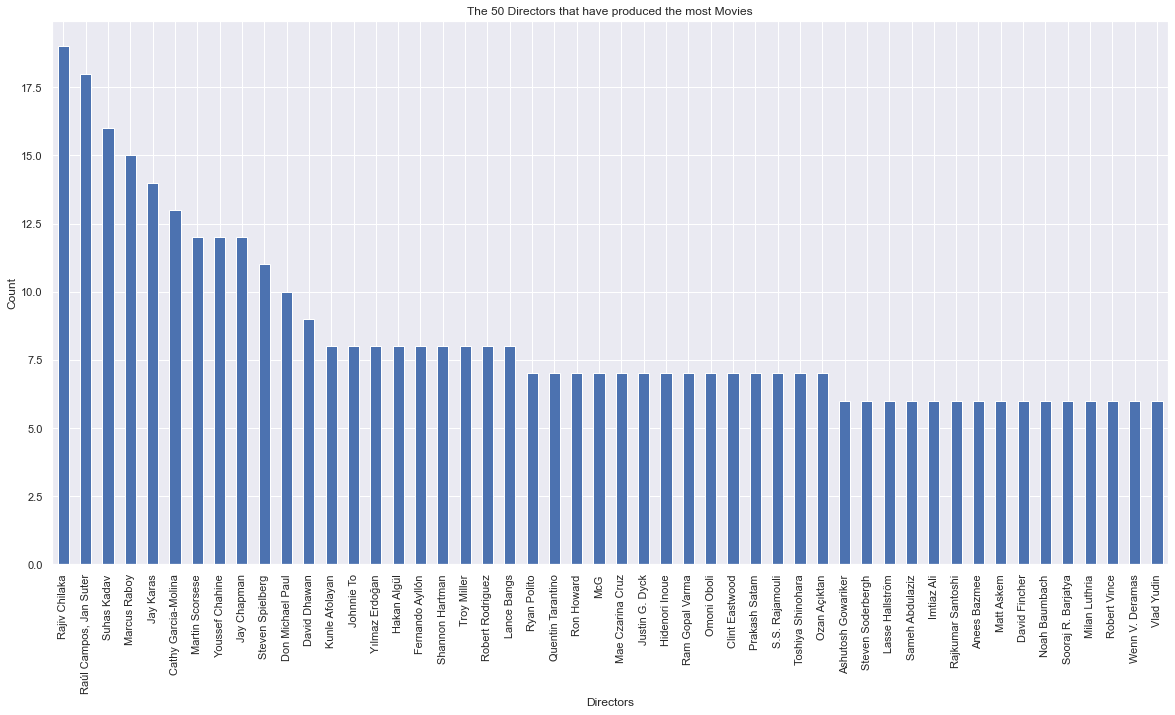

In [36]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
count = df_movies['director'].value_counts()
count =count.iloc[:50]
count.plot(kind='bar', ax=ax)
ax.set_xlabel('Directors')
ax.set_ylabel('Count')
ax.set_title('The 50 Directors that have produced the most Movies')

In [37]:
display(df_basics.shape)
display(df_crew.shape)
df_dir_name = pd.merge(df_crew, df_basics, left_on = 'tconst', right_on = 'tconst', how='left')
df_dir_name = df_dir_name.drop_duplicates(subset='tconst', keep='first')
display(df_dir_name.shape)

df_dir_name = pd.merge(df_dir_name, df_name, left_on = 'directors', right_on = 'nconst', how='left')
df_dir_name = df_dir_name.drop_duplicates(subset='directors', keep='first')
display(df_dir_name.shape)
display(df_dir_name.head())
#df_dir_name.primaryName_z
df_dir = pd.merge(df_movies, df_dir_name, left_on = 'title', right_on = 'primaryTitle', how='left')
df_movies = df_movies.drop_duplicates(subset='title', keep='first')
df_movies.shape
m = df_dir.index[df_dir.director.isna()].to_list()
df_m = df_dir.loc[m]
df_m[['director', 'primaryName']].head()

(114155, 9)

(114155, 3)

(114155, 11)

(59514, 17)

,tconst,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0000004,nm0721526,\N,short,Un bon bock,Un bon bock,0,1892,0,12,"Animation,Short",nm0721526,Émile Reynaud,1844,1918,"director,animation_department,writer","tt2184231,tt0000003,tt13125956,tt2184201"
1,tt0000020,nm0010291,\N,short,The Derby 1895,The Derby 1895,0,1895,0,1,"Documentary,Short,Sport",nm0010291,Birt Acres,1854,1918,"cinematographer,director,producer","tt0282161,tt0000025,tt0000020,tt0000024"
2,tt0000023,nm0525910,\N,short,The Sea,Baignade en mer,0,1895,0,1,"Documentary,Short",nm0525910,Louis Lumière,1864,1948,"producer,director,cinematographer","tt0000014,tt1167665,tt2460076,tt6231346"
4,tt0000051,nm0617588,\N,short,The Bohemian Encampment,Campement de bohémiens,0,1896,0,0,"Documentary,Short",nm0617588,Georges Méliès,1861,1938,"director,actor,producer","tt0002113,tt0000091,tt0215737,tt0223267"
13,tt0000170,nm0666972,\N,short,The Twins' Tea Party,The Twins' Tea Party,0,1896,0,1,"Comedy,Short",nm0666972,Robert W. Paul,1869,1943,"producer,cinematographer,director","tt0250634,tt0000170,tt1867552,tt0001141"


,director,primaryName
337,NaN,NaN
405,NaN,NaN
415,NaN,NaN
416,NaN,Anna Tchernakova
417,NaN,NaN


In [38]:
%%capture --no-display
df_m.director = df_m.primaryName
df_dir.director.iloc[m] = df_m.director

In [39]:
print("Number of missing directors after cleaning: ", df_m.director.isna().sum())

Number of missing directors after cleaning:  160


Text(0.5, 1.0, 'After Cleaning')

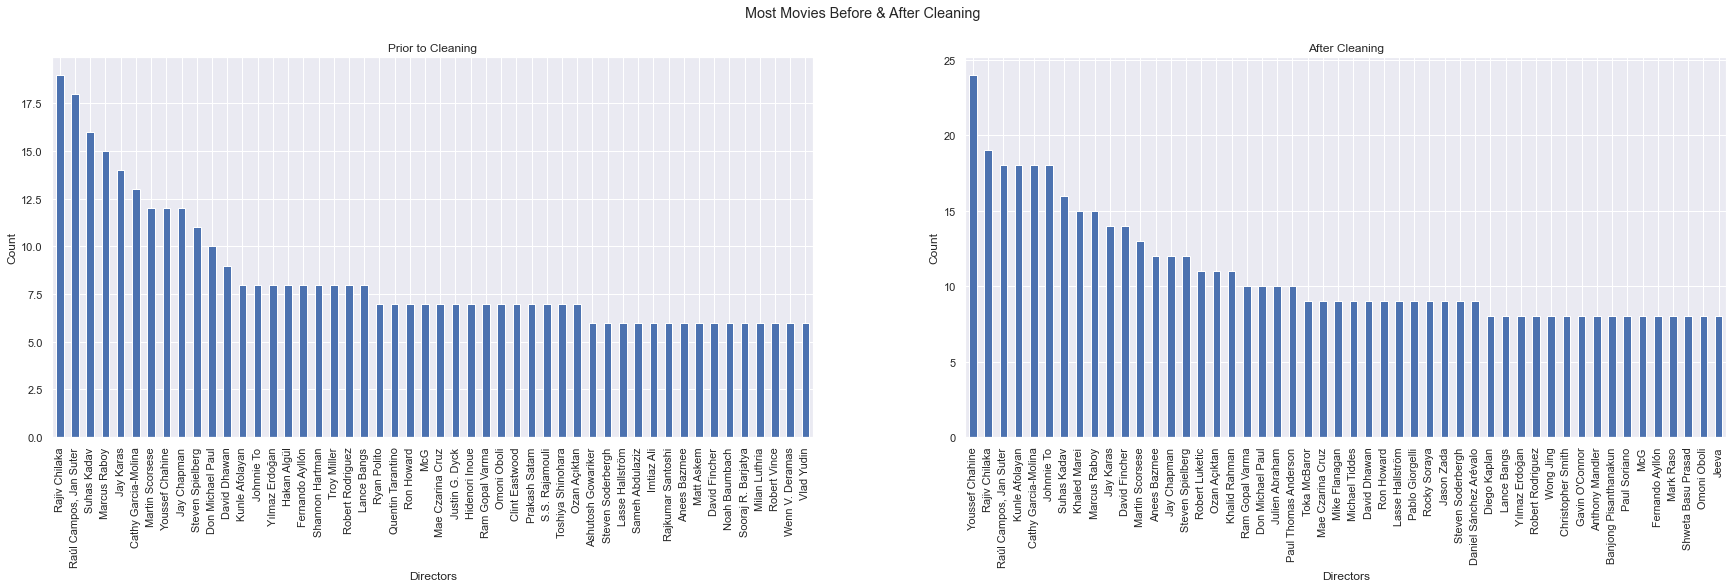

In [40]:
fig, (ax, ax1) = plt.subplots(1,2,figsize=(30,7))
fig.suptitle('Most Movies Before & After Cleaning')
count_b = df_movies['director'].value_counts()
count_b =count_b.iloc[:50]
count_b.plot(kind='bar', ax=ax)
ax.set_xlabel('Directors')
ax.set_ylabel('Count')
ax.set_title('Prior to Cleaning')

count_a = df_dir['director'].value_counts()
count_a =count_a.iloc[:50]
count_l =count_a.iloc[:100]
count_a.plot(kind='bar', ax=ax1)
ax1.set_xlabel('Directors')
ax1.set_ylabel('Count')
ax1.set_title('After Cleaning')

Prior to cleaning the dataset and finding more directors, Rajiv Chilaka was the director who had produced the most movies with 19. However after cleaning, it is found that Youssef Chahine is the director who has produced the most movies on Netflix with 24.

### 1.3.3

In [41]:
df_dir = pd.merge(df_dir, df_ratings, left_on = 'tconst', right_on = 'tconst', how='left')
#df_dir=df_dir.averageRating.fillna(0)
df_dir.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'tconst', 'directors', 'writers', 'titleType', 'primaryTitle',
       'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes',
       'genres', 'nconst', 'primaryName', 'birthYear', 'deathYear',
       'primaryProfession', 'knownForTitles', 'averageRating', 'numVotes'],
      dtype='object')

In [42]:
df_dir.averageRating=df_dir.averageRating.fillna(0)

Text(0.5, 1.0, 'The Average Rating of the Directors in the Top 100')

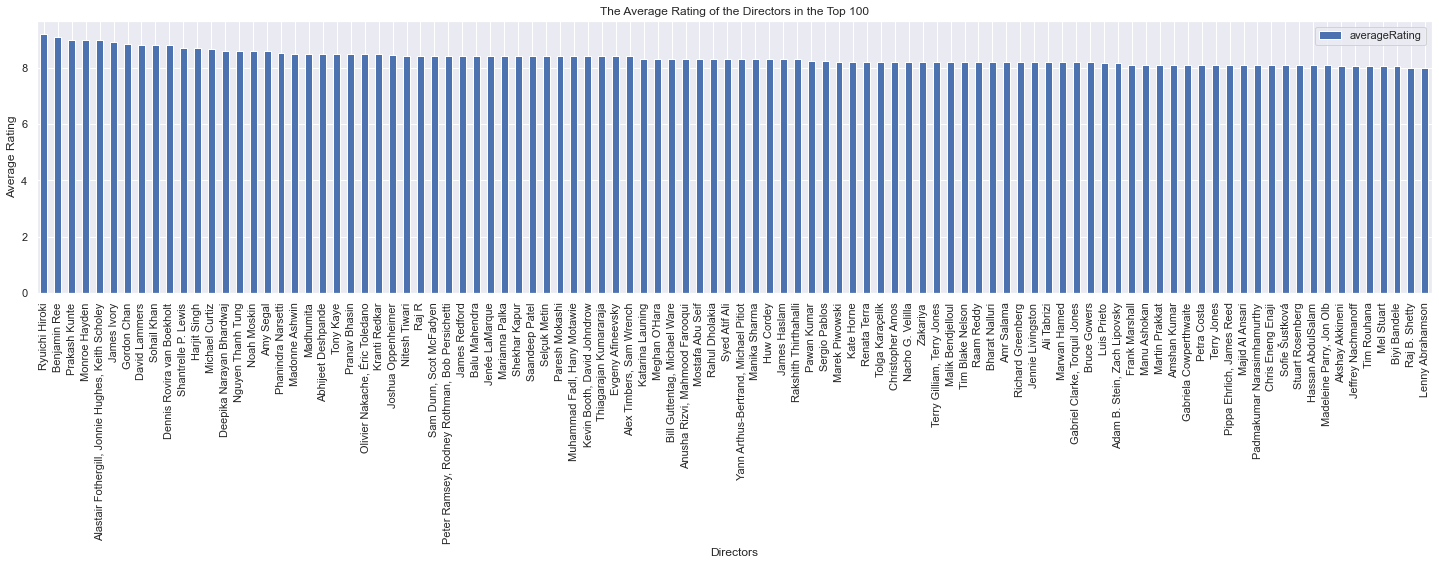

In [43]:
count_a = df_dir[['director', 'averageRating']].groupby('director').mean().sort_values(by='averageRating', ascending=False)
count_a =count_a.iloc[:100]

fig, ax = plt.subplots(1,1,figsize=(25, 5))
count_a.plot(kind='bar', ax=ax)
ax.set_xlabel('Directors')
ax.set_ylabel('Average Rating')
ax.set_title('The Average Rating of the Directors in the Top 100')

In [44]:
%%capture --no-display
youssef = df_dir[df_dir.director == 'Youssef Chahine']
youssef.averageRating = youssef.averageRating.fillna(0)

Youssef's Mean Average Rating 6.980952380952382


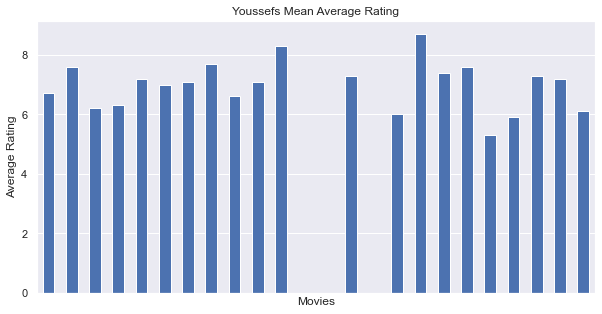

In [45]:
ax = youssef.averageRating.plot(kind='bar', figsize=(10, 5), title='Youssefs Mean Average Rating', ylabel='Average Rating', xticks=[], xlabel='Movies')
ax.set_xticks=['0','5','10','20']
print("Youssef's Mean Average Rating", youssef.averageRating.sum()/21)

Youssef Chihane surpassed Rajiv Chilaka in terms of the number of movies he produced himself, that are on netflix. Unfortunately, despite this Youssef does not even fall into the top 100 directors with the highest average ratings. Ryuichi Hiroki takes top spot with an average of ~8.7, while at he bottom of the top100 we have Lenny Abrahamson with ~8. Youssef have an average Rating across all his movies of 6.98, when not taking the missing values into account.